## Character-level recurrent sequence-to-sequence model

Example from https://keras.io/examples/nlp/lstm_seq2seq/  
Older post https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [19]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import numpy as np
import pandas as pd
import pydot as pyd
from itertools import chain

from sklearn.model_selection import train_test_split
from tensorflow import keras 
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, GRU, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [22]:
with np.load('data/ncbi_02/dataset.npz', allow_pickle = True) as data:
    encoder_input_data = data['encoder_input_data']
    decoder_input_data = data['decoder_input_data']
    decoder_target_data = data['decoder_target_data']
    token_index = data['token_index'].tolist()

In [23]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)
print(token_index)

(4368, 3822, 4)
(4368, 3822, 4)
(4368, 3822, 4)
{'A': 0, 'C': 1, 'G': 2, 'T': 3}


In [59]:
X_data = encoder_input_data[:100]
Y_data = decoder_input_data[:100]
print("X_data", X_data.shape)
print("Y_data", Y_data.shape)

X_data (100, 3822, 4)
Y_data (100, 3822, 4)


In [60]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10811329411870557258
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7248084992
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 17591890609212083803
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 7741702144
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 7194023905782237788
physical_device_desc: "device: 1, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


## Construct model

In [61]:
n_hidden = 32

In [62]:
input_train = Input(shape=(X_data.shape[1], X_data.shape[2]))
output_train = Input(shape=(Y_data.shape[1], Y_data.shape[2]))
print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 4), dtype=tf.float32, name='input_7'), name='input_7', description="created by layer 'input_7'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 4), dtype=tf.float32, name='input_8'), name='input_8', description="created by layer 'input_8'")


In [63]:
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, dropout = 0.05, recurrent_dropout = 0.05, # , activation = 'elu'
    return_sequences = True, return_state = True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 32), dtype=tf.float32, name=None), name='lstm_2/transpose_1:0', description="created by layer 'lstm_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='lstm_2/while:4', description="created by layer 'lstm_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='lstm_2/while:5', description="created by layer 'lstm_2'")


In [64]:
encoder_last_h = BatchNormalization(momentum = 0.6)(encoder_last_h)
encoder_last_c = BatchNormalization(momentum = 0.6)(encoder_last_c)

In [65]:
decoder_input = RepeatVector(Y_data.shape[1])(encoder_last_h)
print(decoder_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 32), dtype=tf.float32, name=None), name='repeat_vector_3/Tile:0', description="created by layer 'repeat_vector_3'")


In [66]:
decoder_stack_h = LSTM(n_hidden, dropout = 0.01, recurrent_dropout = 0.01, # , activation='elu'
 return_state = False, return_sequences = True)(
 decoder_input, initial_state = [encoder_last_h, encoder_last_c])
print(decoder_stack_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 32), dtype=tf.float32, name=None), name='lstm_3/transpose_1:0', description="created by layer 'lstm_3'")


In [67]:
attention = dot([decoder_stack_h, encoder_stack_h], axes = [2, 2])
attention = Activation('softmax')(attention)
print(attention)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 3822), dtype=tf.float32, name=None), name='activation_1/Softmax:0', description="created by layer 'activation_1'")


In [68]:
context = dot([attention, encoder_stack_h], axes = [2,1])
context = BatchNormalization(momentum = 0.6)(context)
print(context)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 32), dtype=tf.float32, name=None), name='batch_normalization_7/batchnorm/add_1:0', description="created by layer 'batch_normalization_7'")


In [69]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 64), dtype=tf.float32, name=None), name='concatenate_1/concat:0', description="created by layer 'concatenate_1'")


In [70]:
out = TimeDistributed(Dense(Y_data.shape[2], activation = "softmax"))(decoder_combined_context)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 4), dtype=tf.float32, name=None), name='time_distributed_2/Reshape_1:0', description="created by layer 'time_distributed_2'")


In [71]:
model = Model(inputs = input_train, outputs = out)
opt = keras.optimizers.Adam(learning_rate = 0.01, clipnorm = 1)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 3822, 4)]    0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 3822, 32), ( 4736        input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 32)           128         lstm_2[0][1]                     
__________________________________________________________________________________________________
repeat_vector_3 (RepeatVector)  (None, 3822, 32)     0           batch_normalization_5[0][0]      
____________________________________________________________________________________________

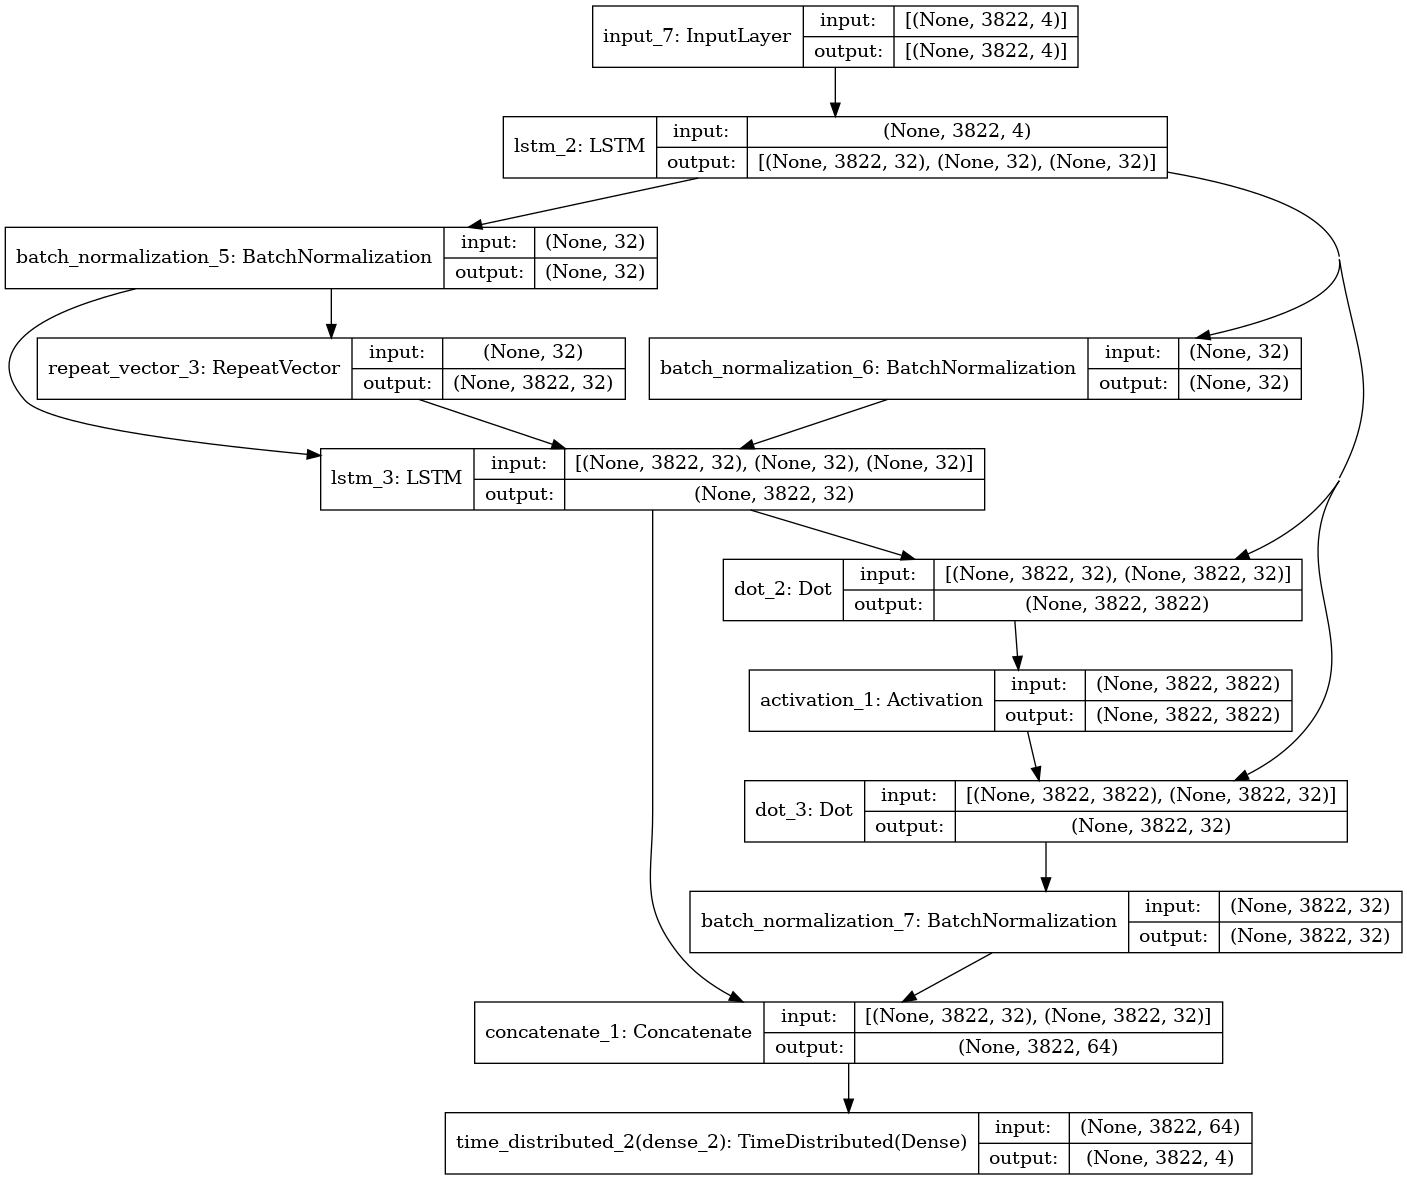

In [72]:
keras.utils.plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

## Train model

In [73]:
batch_size = 16      # Batch size for training.
patience = 10        # Patience for EarlyStop
epochs = 1000        # Number of epochs to train for.

In [74]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = patience, restore_best_weights = True)
history = model.fit(X_data, Y_data, validation_split = 0.2, 
                    epochs = epochs, verbose = 1, callbacks = [ es ], 
                    batch_size = batch_size)
train_mae = history.history['accuracy']
valid_mae = history.history['val_accuracy']

Epoch 1/1000
5/5 [==============================] - 38s 7s/step - loss: 1.3697 - accuracy: 0.3015 - val_loss: 1.3573 - val_accuracy: 0.3328
Epoch 2/1000
5/5 [==============================] - 36s 7s/step - loss: 1.3557 - accuracy: 0.3306 - val_loss: 1.3548 - val_accuracy: 0.3328
Epoch 3/1000
5/5 [==============================] - 36s 7s/step - loss: 1.3543 - accuracy: 0.3279 - val_loss: 1.3624 - val_accuracy: 0.3328
Epoch 4/1000
5/5 [==============================] - 36s 7s/step - loss: 1.3534 - accuracy: 0.3327 - val_loss: 1.3578 - val_accuracy: 0.3328
Epoch 5/1000
5/5 [==============================] - 36s 7s/step - loss: 1.3528 - accuracy: 0.3327 - val_loss: 1.3540 - val_accuracy: 0.3328
Epoch 6/1000
5/5 [==============================] - 36s 7s/step - loss: 1.3527 - accuracy: 0.3327 - val_loss: 1.3529 - val_accuracy: 0.3328
Epoch 7/1000
5/5 [==============================] - 36s 7s/step - loss: 1.3526 - accuracy: 0.3327 - val_loss: 1.3525 - val_accuracy: 0.3328
Epoch 8/1000
5/5 [==

5/5 [==============================] - 37s 7s/step - loss: 1.3473 - accuracy: 0.3335 - val_loss: 1.3467 - val_accuracy: 0.3339
Epoch 60/1000
5/5 [==============================] - 37s 7s/step - loss: 1.3469 - accuracy: 0.3340 - val_loss: 1.3465 - val_accuracy: 0.3339
Epoch 61/1000
5/5 [==============================] - 37s 7s/step - loss: 1.3466 - accuracy: 0.3342 - val_loss: 1.3466 - val_accuracy: 0.3349
Epoch 62/1000
5/5 [==============================] - 37s 8s/step - loss: 1.3466 - accuracy: 0.3342 - val_loss: 1.3463 - val_accuracy: 0.3344
Epoch 63/1000
5/5 [==============================] - 37s 7s/step - loss: 1.3463 - accuracy: 0.3342 - val_loss: 1.3469 - val_accuracy: 0.3339
Epoch 64/1000
5/5 [==============================] - 37s 8s/step - loss: 1.3464 - accuracy: 0.3340 - val_loss: 1.3471 - val_accuracy: 0.3344
Epoch 65/1000
5/5 [==============================] - 37s 8s/step - loss: 1.3479 - accuracy: 0.3311 - val_loss: 1.3493 - val_accuracy: 0.3003
Epoch 66/1000
5/5 [========

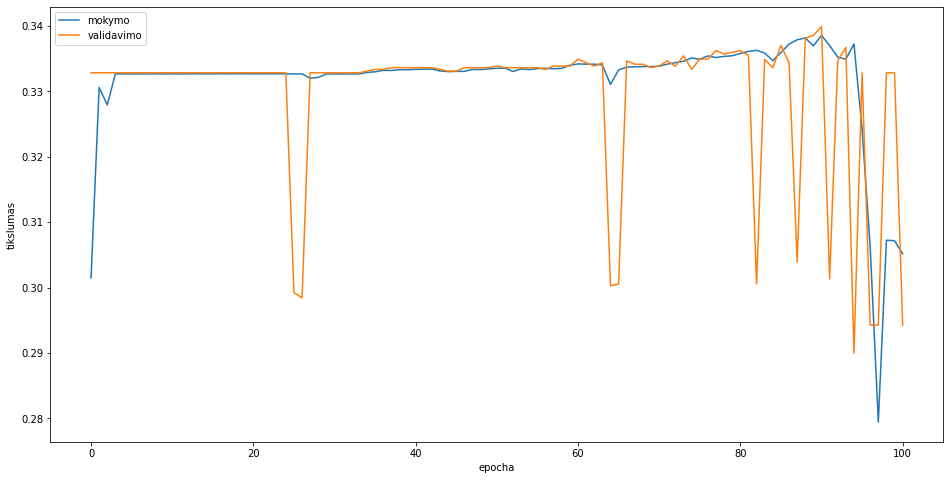

In [76]:
plt.plot(train_mae, label = 'mokymo')
plt.plot(valid_mae, label = 'validavimo')
plt.ylabel('tikslumas')
plt.xlabel('epocha')
plt.legend()
plt.show()

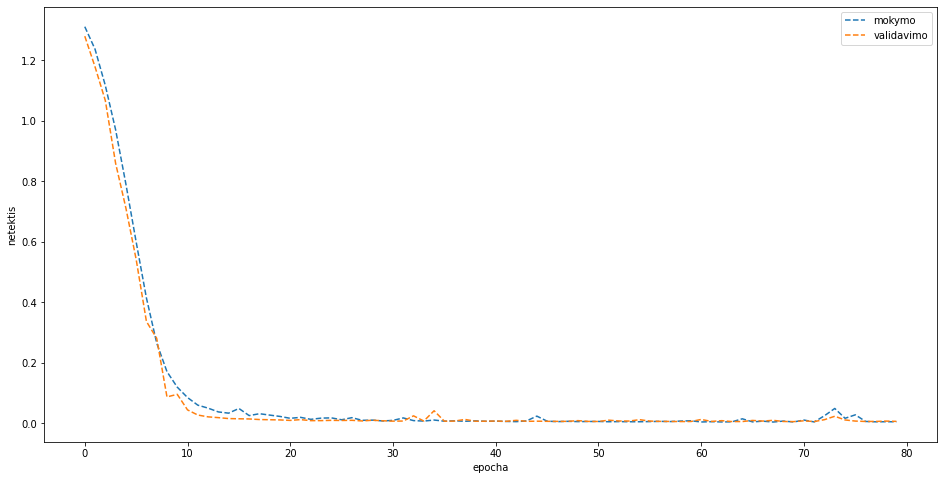

In [13]:
plt.plot(log.history['loss'], '--', label = 'mokymo')
plt.plot(log.history['val_loss'], '--', label = 'validavimo')
plt.ylabel('netektis')
plt.xlabel('epocha')
plt.legend()
plt.show()

In [14]:
model.save("data/ncbi_02/model_gru_bi_256")

2021-10-07 10:59:42.345759: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: data/ncbi_02/model_gru_bi_256/assets


INFO:tensorflow:Assets written to: data/ncbi_02/model_gru_bi_256/assets
